In [56]:
# import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import yfinance as yf
from datetime import datetime

In [124]:
income_statement_file = "Profit&Loss.csv"
df = pd.read_csv(income_statement_file)

print(f'Original Data Shape: {df.shape}')

# Set first column as index
df = df.set_index("Date")

Original Data Shape: (20, 33)


In [125]:
# Removed all columns having all 0s
df = df.drop(df.columns[df.eq(0).all()], axis=1)

# Data cleaning by dropping NaN
df = df.dropna(thresh=1)

# Force data column data to be numeric by removing comma
df = df.replace(',', '', regex=True)
df = df.apply(pd.to_numeric)

print(f'Cleaned Data Shape: {df.shape}')

Cleaned Data Shape: (20, 31)


In [126]:
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Set the threshold
threshold = 0.99

# Identify highly correlated features
high_corr_features = np.where(corr_matrix > threshold)

# Remove highly correlated features
high_corr_features = []
for x, y in zip(*high_corr_features): 
    if x != y and x < y:
        col_x_y = (corr_matrix.columns[x], corr_matrix.columns[y]) 
        high_corr_features.append(col_x_y)
        
for feature in high_corr_features:
    df.drop(feature[1], axis=1 ,inplace=True ,errors='ignore')

print(f'Uncorelated Data Shape: {df.shape}')    

Uncorelated Data Shape: (20, 31)


In [46]:
# plt.rcParams['figure.figsize'] = df.shape
# sns.heatmap(df.corr())
# plt.show()

In [87]:

def get_last_day_price(symbol, quarter, year):
    quarters = {"Q1":3, "Q2":6, "Q3": 9, "Q4": 12}
    month = quarters[quarter]
    year_month = f'{year}-0{month}'
    start_day = f"{year_month}-21"
    end_day = f"{year_month}-29"
    start_day = datetime.strptime(start_day, "%Y-%m-%d")
    end_day = datetime.strptime(end_day, "%Y-%m-%d")
    # Download historical data for RELIANCE.NS from 2023-03-01 to 2023-03-31
    reliance = yf.download("RELIANCE.NS", start=start_day, end=end_day, progress=False)

    # Calculate the difference between the open and close prices for 2023-03-31
    last_day_price = reliance.iloc[-1]
    price_diff = last_day_price['Close'] - last_day_price['Open']
    # print(last_day_price)
    # print(f"Price difference: ", price_diff)
    return price_diff

def get_price(df, symbol):
    df_index = df.index.to_list()
    price_dict = {}
    for i in df_index:
        year, month = i.split('-')
        year = f'20{year}' if len(year)==2 else f'200{year}'
        month = 'Q1'
        price = get_last_day_price(symbol, month, year)
        price_dict[i] = price
    # y_df = pd.DataFrame(price_dict)
    y_df = pd.DataFrame.from_dict(ydf, orient='index', columns=['Price'])
    y_df.index.name = 'Date'
    return y_df
    

In [129]:
symbol = 'RELIANCE.NS'
ydf = get_price(df, symbol)

In [134]:
x = df
y = ydf

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3, random_state=0)

# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Predicting the Test & Train set results
y_test_pred = regressor.predict(x_test)
y_train_pred = regressor.predict(x_train)

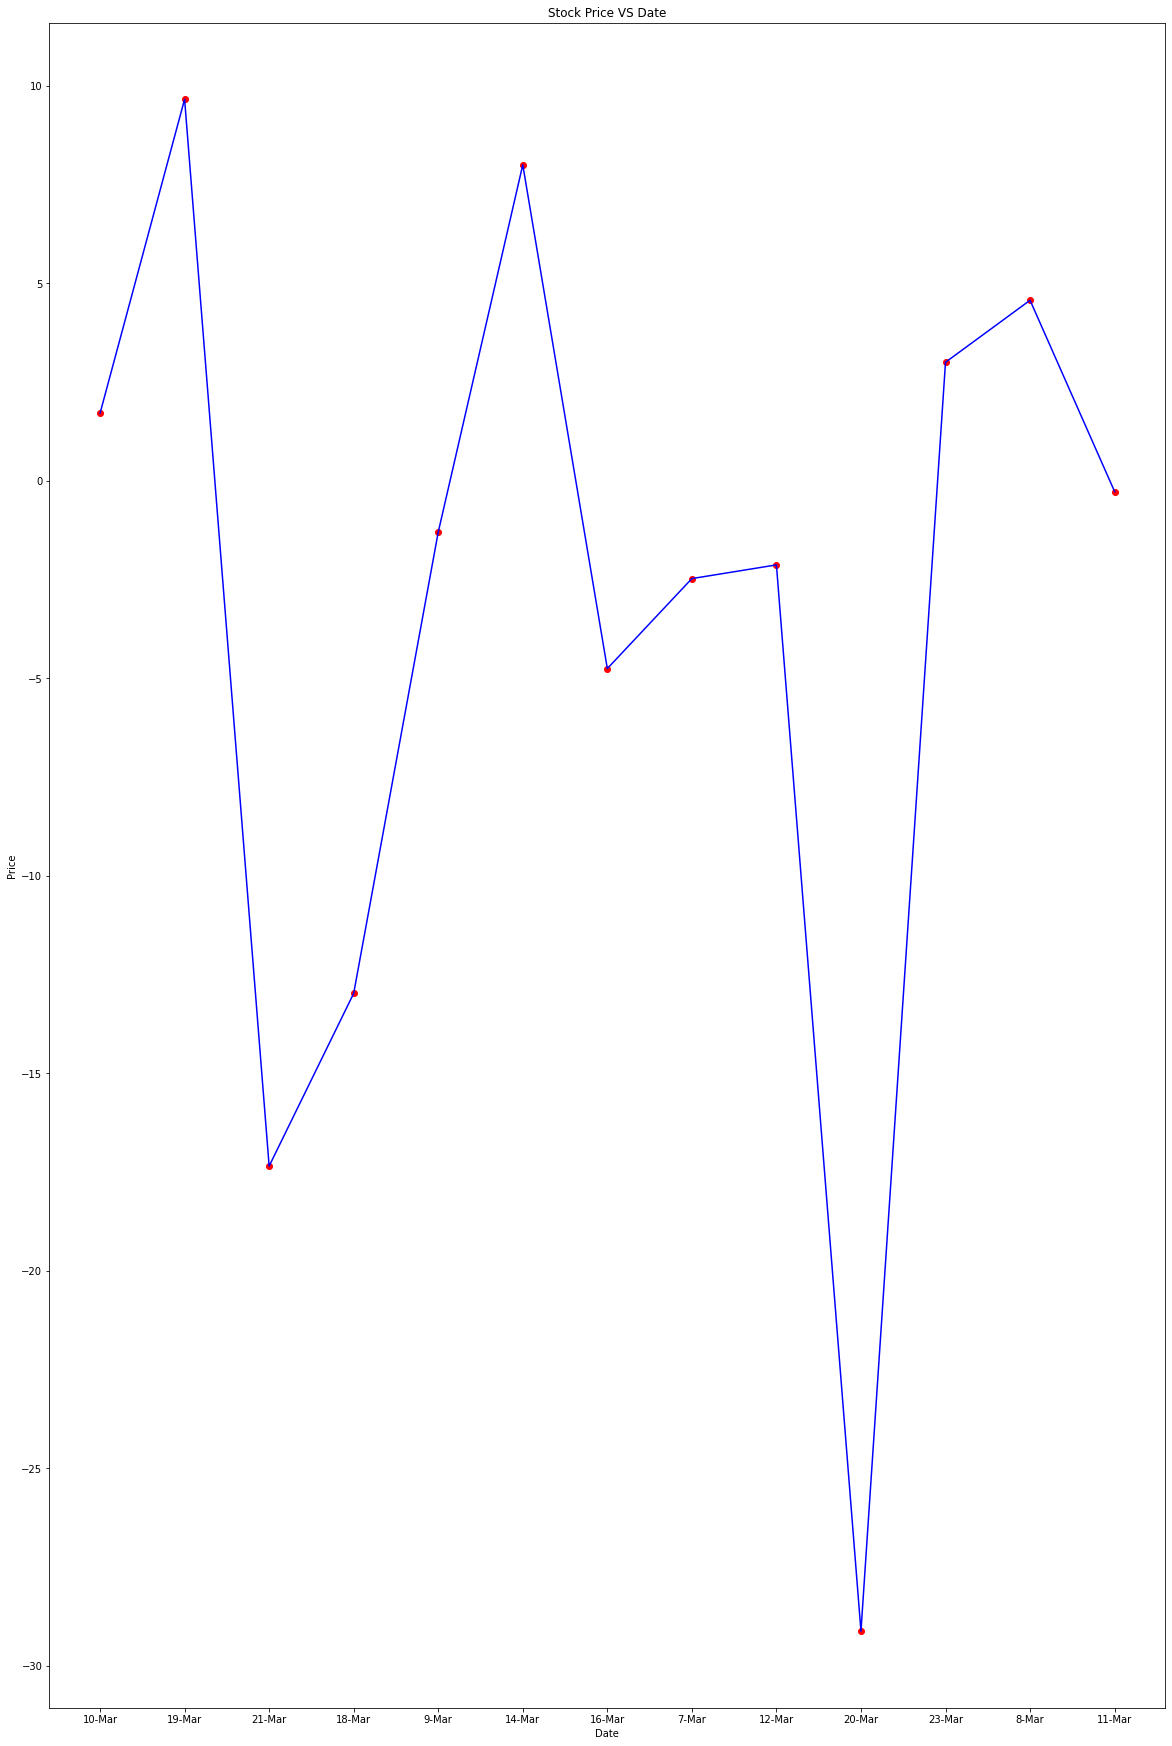

In [138]:
# Visualizing the Training set results
viz_train = plt
viz_train.scatter(x_train.index, y_train, color='red')
viz_train.plot(x_train.index, y_train_pred, color='blue')
viz_train.title('Stock Price VS Date')
viz_train.xlabel('Date')
viz_train.ylabel('Price')
viz_train.show()

